<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Importing Packages</h2>

In [81]:
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
np.random.seed(20)

In [82]:
spam_df = pd.read_csv("spam.csv", encoding='latin-1', usecols=['v1', 'v2'])

spam_df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [83]:
spam_df.dropna(how='any', inplace=True, axis=1)
spam_df.columns=['type','text']
# Binary target column
spam_df['target'] = spam_df['type'].map({'ham':0, 'spam':1})

print(spam_df.shape)
spam_df.head(10)

(5572, 3)


,type,text,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Exploratory Data Analysis</h2>

In [84]:
spam_df.describe()

,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [85]:
print('Number of duplicate entries:',
      spam_df.duplicated().sum())

Number of duplicate entries: 403


Text(0.5, 1.0, 'Target Distribution')

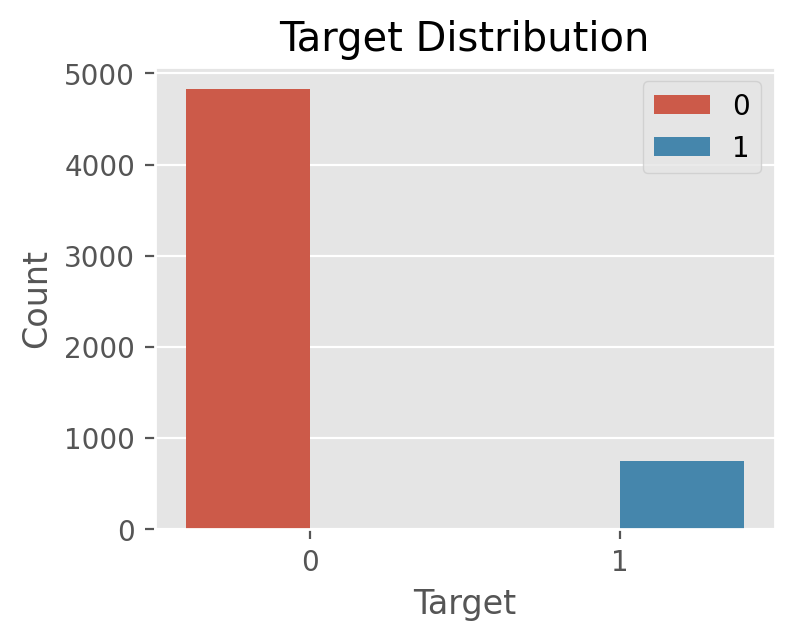

In [86]:
plt.figure(figsize=(4,3), dpi=200)

sns.barplot(x=spam_df['target'].value_counts().index,
            y=spam_df['target'].value_counts(),
            hue=spam_df['target'].value_counts().index)

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')

In [87]:
spam_df['word_count'] = spam_df['text'].apply(lambda x: len(x.split()))
spam_df['char_count'] = spam_df['text'].apply(len)

spam_df.head()

,type,text,target,word_count,char_count
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,111
1,ham,Ok lar... Joking wif u oni...,0,6,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,155
3,ham,U dun say so early hor... U c already then say...,0,11,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,61


Text(0.5, 0, 'Word Count')

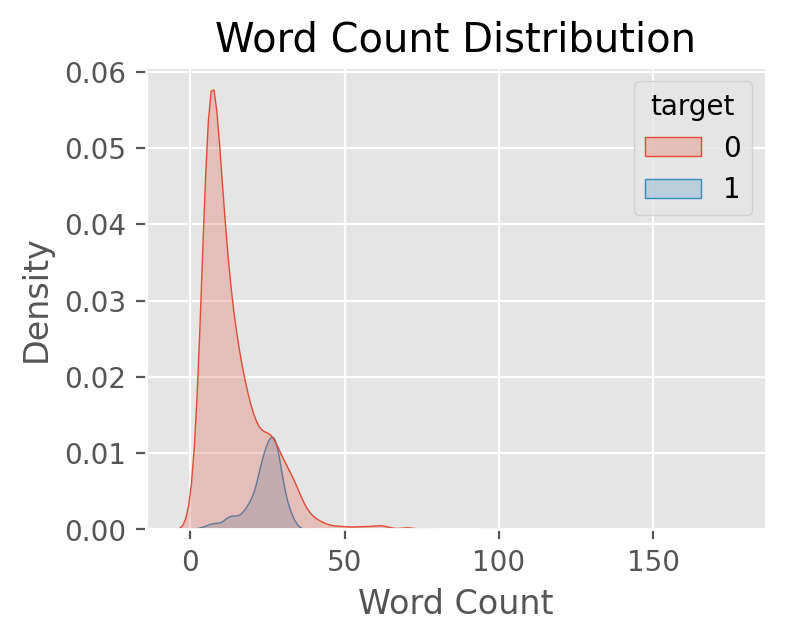

In [88]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=spam_df, x='word_count',
            hue='target',
            fill=True)

plt.title('Word Count Distribution')
plt.xlabel('Word Count')

Text(0.5, 0, 'Character Count')

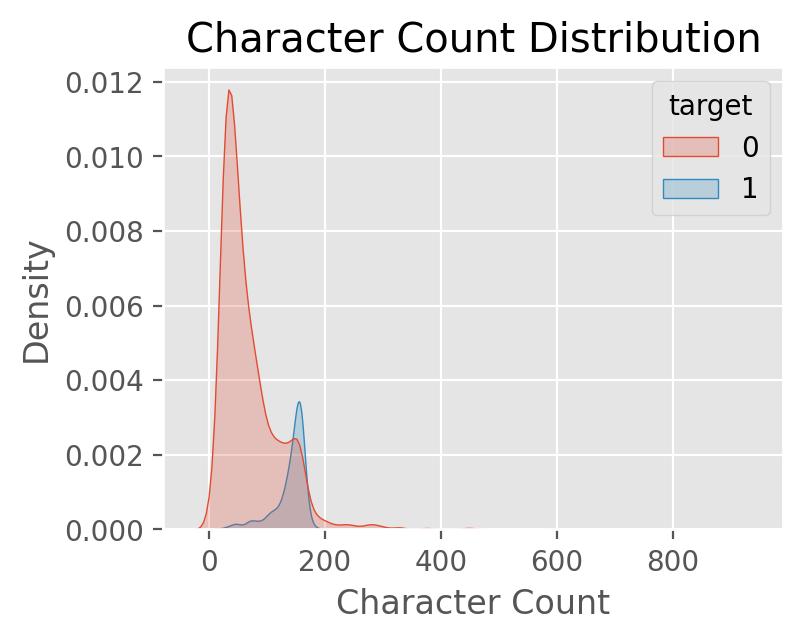

In [89]:
plt.figure(figsize=(4,3), dpi=200)

sns.kdeplot(data=spam_df, x='char_count',
            hue='target',
            fill=True)

plt.title('Character Count Distribution')
plt.xlabel('Character Count')

In [90]:
print(spam_df.groupby('target').describe()['char_count'])

         count        mean        std   min    25%    50%    75%    max
target                                                                 
0       4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
1        747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Helper Functions</h2>

<div style="background-color: #000000; text-align: justify; width: 600px; padding: 10px; border-radius: 10px;">
    <ul style="color: #ffffff; font-size: 16px; text-align: justify; padding: 25px; margin-top: 0;">
        <li>
            <strong style="color: #b09302;">plot_confusion_matrix:</strong>
            This function generates and visualizes a confusion matrix for the given model's predictions on the input data, including accuracy and normalized values.
        </li>
        <li>
            <strong style="color: #b09302;">build_model_pipeline:</strong>
            It creates a text classification pipeline using TF-IDF vectorization and the specified model, streamlining the model-building process.
        </li>
        <li>
            <strong style="color: #b09302;">plot_roc:</strong>
            This function plots the Receiver Operating Characteristic (ROC) curve for the model's predictions, providing insights into its performance and area under the curve (AUC) score.
        </li>
        <li>
            <strong style="color: #b09302;">evaluate_model:</strong>
            Given a model and input data, it evaluates and returns a DataFrame with precision, recall, and F1-score metrics for each class in the classification task, facilitating model assessment and comparison.
        </li>
    </ul>
</div>


In [91]:
def plot_confusion_matrix(model, X, y, ax, **kwargs):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)
    cm_norm = cm / cm.sum(1).reshape((-1, 1))
    labels = [f"{v}\n({pct:.2%})" for v, pct in zip(cm.flatten(), cm_norm.flatten())]
    labels = np.array(labels).reshape(cm.shape)

    sns.heatmap(cm, annot=labels, fmt="",
                ax=ax, yticklabels=le.classes_,
                xticklabels=le.classes_, cbar=False,
               cmap=["#1f1e1a", "#b09302"])
    ax.set_title(f"{kwargs.get('name').upper()} - {acc:.2%}", size=10.5, alpha=0.65)


def build_model_pipeline(model, name):
    pipeline = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(min_df=2, stop_words=list(ENGLISH_STOP_WORDS))),
        (name, model)
    ])
    return pipeline


def plot_roc(model, X, y, ax, **kwargs):
    pred_prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, pred_prob)
    fpr, tpr, threshold = roc_curve(y, pred_prob)

    ax.plot(fpr, tpr, label=f'{kwargs.get("name")} - AUC = {auc:.2%}')
    straight_line = np.linspace(0, 1, len(fpr))
    ax.plot(straight_line, straight_line)
    ax.fill_between(fpr, fpr, tpr, alpha=0.1)
    ax.legend(loc=4, frameon=True, edgecolor="gray")
    ax.set_title("ROC Curve", size=11)
    ax.grid(visible=False, axis="y")
    ax.set(ylabel="tpr", xlabel="fpr")


def evaluate_model(model, X, y, name):
    pred = model.predict(X)
    prf = precision_recall_fscore_support(y, pred)[:-1]
    metrics = "precision_recall_fscore".split("_")
    arrays = [["", name, ""], metrics]
    index = pd.MultiIndex.from_arrays(arrays, names=('model', 'metric'))
    df = pd.DataFrame(prf, columns=le.classes_, index=index)

    return df

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Preprocessing Text</h2>

In [92]:
def process_text(message):
    text_split = message.lower().split()
    texts = [word for word in text_split if word not in string.punctuation]
    texts = [re.sub("[^a-zA-Z]", " ", word).strip() for word in texts]
    texts = " ".join(texts)
    texts = [word for word in texts.split() if word not in ENGLISH_STOP_WORDS and len(word)>1]

    return " ".join(texts)

In [93]:
process_text("Todays Voda numbers ending 1225 are selected to receive a å£50award. \
            If you have a match please call 08712300220 quoting claim code 3100 standard rates app")

'todays voda numbers ending selected receive award match quoting claim code standard rates app'

In [94]:
spam_df['text'] = spam_df['text'].apply(process_text)

spam_df.sample(5)

,type,text,target,word_count,char_count
4732,ham,good morning dear shijutta great amp successfu...,0,11,75
4952,ham,lost pounds doc visit week woot woot gonna cel...,0,20,100
3724,ham,spl wat abt whr ru,0,7,34
5261,ham,absolutely love south park recently started wa...,0,12,74
1274,ham,let know contact ve settled room lets know ok,0,18,81


In [95]:
le = LabelEncoder()

spam_df.reset_index(drop=True, inplace=True)
x = spam_df.text
y = le.fit_transform(spam_df.type)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 50px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Evaluating Models</h2>

In [96]:
models = {
    "nb": build_model_pipeline(MultinomialNB(), "nb").fit(x_train, y_train),
    "knn": build_model_pipeline(KNeighborsClassifier(n_neighbors=70), "knn").fit(x_train, y_train),
    "lr": build_model_pipeline(LogisticRegression(solver="liblinear"), "lr").fit(x_train, y_train),
    "rfc": build_model_pipeline(RandomForestClassifier(max_depth=10), "rfc").fit(x_train, y_train)
}

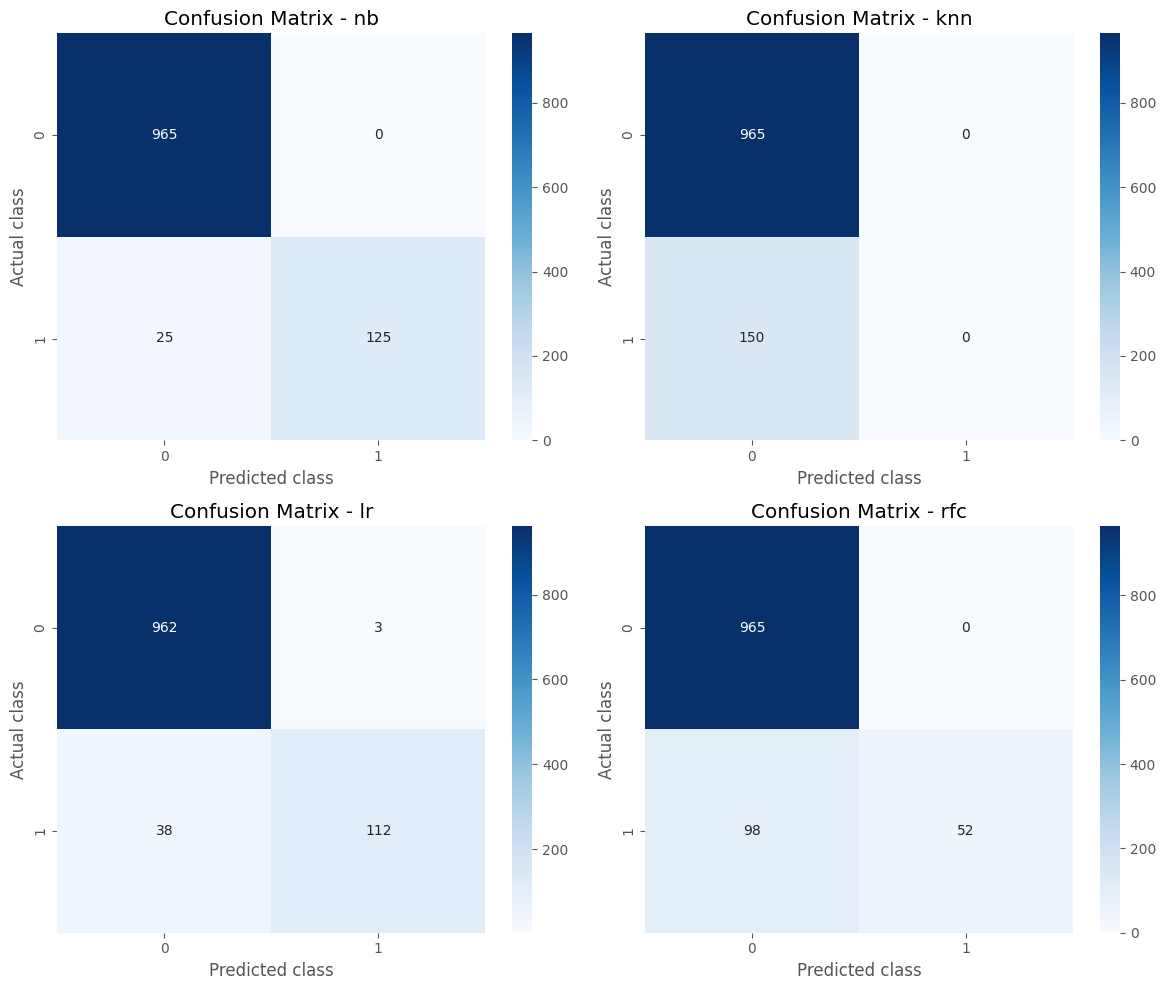

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted class')
    axes[i].set_ylabel('Actual class')

plt.tight_layout()
plt.show()



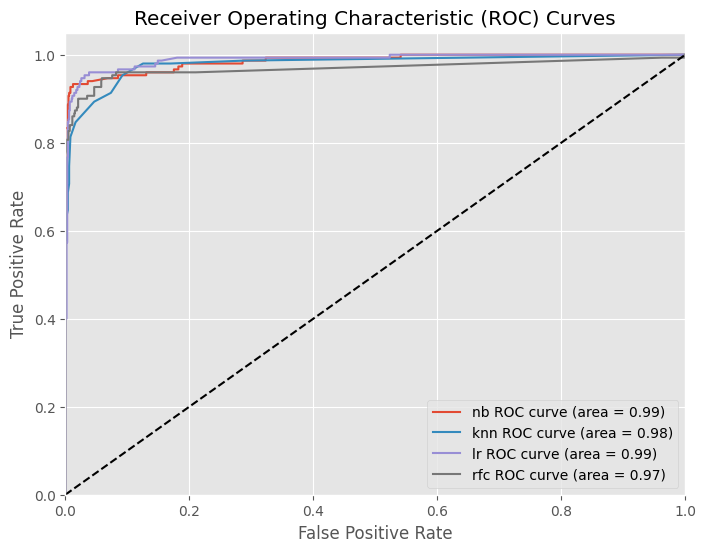

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    preds = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()




<h2 style="background-color: #000000; padding: 10px; width: 600px; font-size: 30px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px; color: #b09302">Interpretation of AUC</h2>
    
<div style="background-color: #000000; width: 600px; color: #ffffff; font-size: 16px; text-align: justify; padding: 10px; border-radius: 10px;">   
<p style="color: #ffffff;">
    <strong style="color: #b09302;">Naive Bayes:</strong>
    AUC at 0.9947 reflects an outstanding ability to separate positive and negative instances, showcasing the model's high accuracy in classification tasks.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">KNN:</strong>
    Despite a slightly lower AUC at 0.9246, KNN displays good discriminatory prowess, striking a balance between true positives and false positives.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">Logistic Regression:</strong>
    The exceptionally high AUC of 0.9973 underscores the model's remarkable accuracy, indicating superior performance in correctly classifying instances.
</p>

<p style="color: #ffffff;">
    <strong style="color: #b09302;">Random Forest:</strong>
    With an AUC of 0.9947, Random Forest showcases robust discriminatory performance, akin to Naive Bayes.
</p>
</div>

In [103]:
results_df = None

for i, (model_name, model) in enumerate(models.items()):
    model_results = evaluate_model(
        models[model_name], x_test, y_test, name=model_name.upper())
    if i == 0:
        results_df = model_results.copy()
    else:
        results_df = pd.concat((results_df, model_results))

results_df

ham      spam
model metric                       
      precision  0.974747  1.000000
NB    recall     1.000000  0.833333
      fscore     0.987212  0.909091
      precision  0.865471  0.000000
KNN   recall     1.000000  0.000000
      fscore     0.927885  0.000000
      precision  0.962000  0.973913
LR    recall     0.996891  0.746667
      fscore     0.979135  0.845283
      precision  0.907808  1.000000
RFC   recall     1.000000  0.346667
      fscore     0.951677  0.514851